Found 33120 images belonging to 5 classes.
Found 8279 images belonging to 5 classes.
Epoch 1/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5232s 5s/step - accuracy: 0.8061 - loss: 0.4893 - val_accuracy: 0.9053 - val_loss: 0.2472
Epoch 2/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5082s 5s/step - accuracy: 0.8998 - loss: 0.2577 - val_accuracy: 0.9215 - val_loss: 0.2082
Epoch 3/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5117s 5s/step - accuracy: 0.9113 - loss: 0.2316 - val_accuracy: 0.9284 - val_loss: 0.1986
Epoch 4/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5081s 5s/step - accuracy: 0.9203 - loss: 0.2119 - val_accuracy: 0.9313 - val_loss: 0.1890
Epoch 5/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5156s 5s/step - accuracy: 0.9246 - loss: 0.1974 - val_accuracy: 0.9341 - val_loss: 0.1804
Epoch 6/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5164s 5s/step - accuracy: 0.9325 - loss: 0.1792 - val_accuracy: 0.9289 - val_loss: 0.1904
Epoch 7/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5073s 5s/step - accuracy: 0.9348 - loss: 0.1760 - val_accuracy: 0.9371 - val_loss

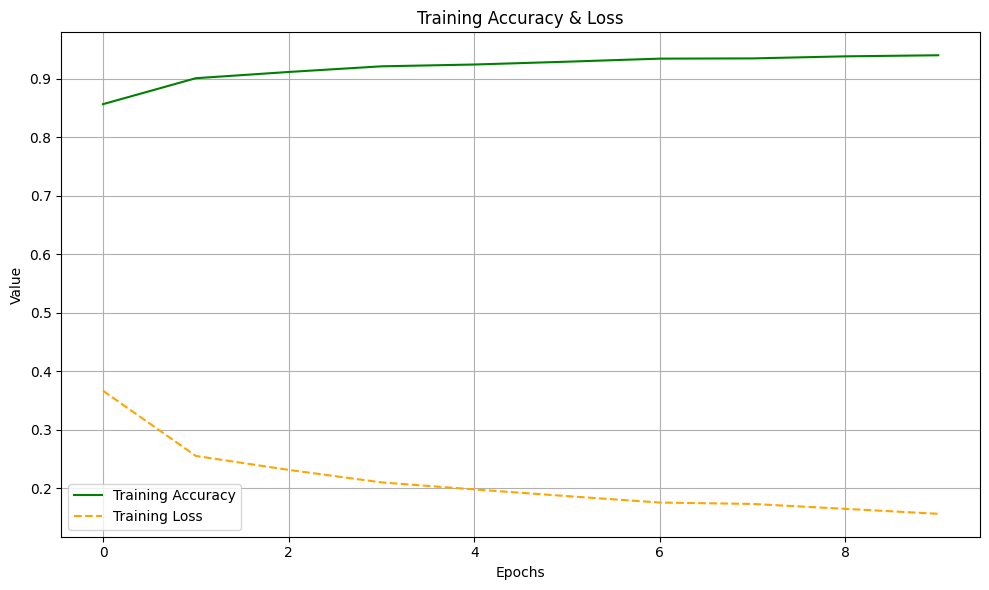

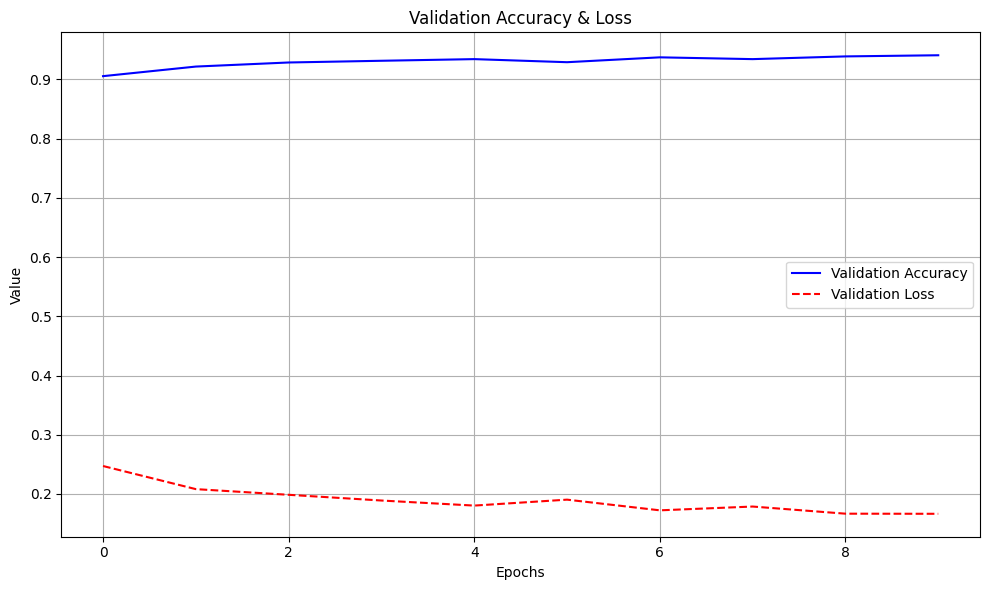

259/259 ━━━━━━━━━━━━━━━━━━━━ 1180s 5s/step


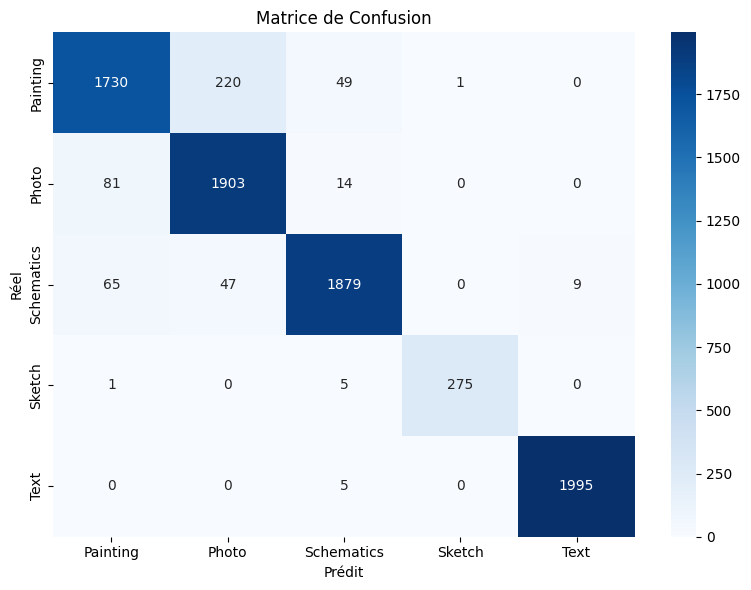


Rapport de classification :

              precision    recall  f1-score   support

    Painting       0.92      0.86      0.89      2000
       Photo       0.88      0.95      0.91      1998
  Schematics       0.96      0.94      0.95      2000
      Sketch       1.00      0.98      0.99       281
        Text       1.00      1.00      1.00      2000

    accuracy                           0.94      8279
   macro avg       0.95      0.95      0.95      8279
weighted avg       0.94      0.94      0.94      8279



In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# Paramètres
img_height, img_width = 224, 224
batch_size = 32
num_classes = 5
epochs = 10

# Préparation des données
data_dir = "Dataset"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important pour aligner les prédictions avec les vraies étiquettes
)

class_names = list(val_generator.class_indices.keys())

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

model.save("vgg16_image_classifier.h5")

# === GRAPHE 1 : Training Accuracy & Loss ===
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
plt.plot(epochs_range, loss, label='Training Loss', color='orange', linestyle='--')
plt.title('Training Accuracy & Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === GRAPHE 2 : Validation Accuracy & Loss ===
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', linestyle='--')
plt.title('Validation Accuracy & Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === MATRICE DE CONFUSION ===
# Prédictions sur le jeu de validation
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

# Affichage du rapport de classification
print("\nRapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=class_names))
